# Task 1: Classification

1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Dataset: 
Downloads the FashionMNIST dataset in your local directory ./data  
The following code shows how to access and visualize the data.

In [73]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset1 = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset1 = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset1.class_to_idx.items()}

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


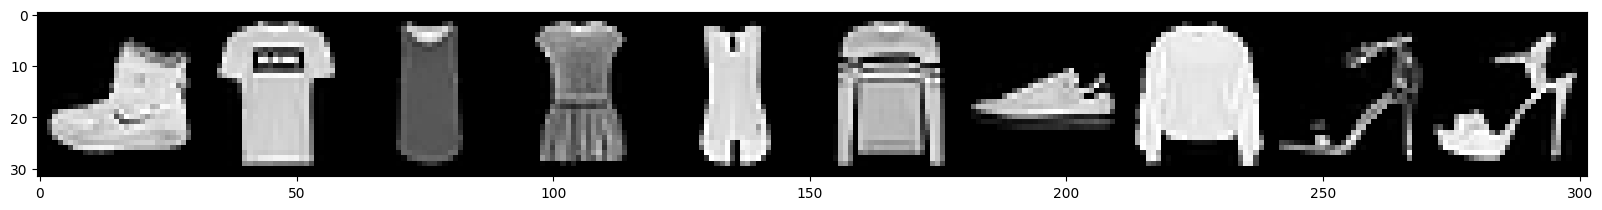

In [74]:
x = [train_dataset1[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset1[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20, 10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

## Model Architecture:
A simple Conv-Layers with droput and maxpooling and a backend of dense-layers.

In [75]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # self.conv3 = nn.Conv2d(64, 128, 3, 1) # learns more abstract things e.g. objects in contrast to conv1 and conv2
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(9216, 2048)
        self.fc2 = nn.Linear(2048, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 12x12x64

        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        return x # raw logits - log-softmax not neccessary since cross-entropy accounts for it

## Training- and Test-Routine:

In [79]:
def train_classification_model(
    model, 
    device, 
    train_loader, 
    optimizer, 
    epoch
):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader): # target label - ground truth
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            data_processed_so_far = batch_idx * len(data)
            total_data = len(train_loader.dataset)
            progress = 100. * batch_idx / len(train_loader)
            print("Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, data_processed_so_far, total_data, progress, loss.item()
            ), end="\r")


def test_classification_model(
    model, 
    device, 
    test_loader, 
    epoch
):
    model.eval()
    test_loss = 0.
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction="sum").item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    total_data = len(test_loader.dataset)
    test_loss /= total_data
    progress = 100. * correct / total_data
    print("Test Set (Epoch {}): Average Loss: {:.4f}\tAccuracy: {}/{} ({:.0f}%){}".format(
        epoch, test_loss, correct, total_data, progress, 80 * " "
    ))

## Hyperparameters with Training-Loop:

In [82]:
def train_model(
    model, 
    device,
    train_loader,
    test_loader,
    train_func,
    test_func,
    lr=0.001, 
    step_size=5, 
    gamma=0.1, 
    epochs=10,
    **additional_params
):
    train_params = additional_params.pop("train_params", {})
    test_params = additional_params.pop("test_params", {})
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    for epoch in range(1, epochs + 1):
        train_func(model, device, train_loader, optimizer, epoch, **train_params)
        test_func(model, device, test_loader, epoch, **test_params)
        scheduler.step()

In [96]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset1, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
cnn_model = CNN().to(device=device)
train_model(
    cnn_model,
    device,
    train_loader,
    test_loader,
    train_classification_model, 
    test_classification_model
)

Test Set (Epoch 1): Average Loss: 0.3596	Accuracy: 8701/10000 (87%)                                                                                
Test Set (Epoch 2): Average Loss: 0.2713	Accuracy: 9003/10000 (90%)                                                                                
Test Set (Epoch 3): Average Loss: 0.2765	Accuracy: 9058/10000 (91%)                                                                                
Test Set (Epoch 4): Average Loss: 0.2707	Accuracy: 9140/10000 (91%)                                                                                
Test Set (Epoch 5): Average Loss: 0.2923	Accuracy: 9155/10000 (92%)                                                                                
Test Set (Epoch 6): Average Loss: 0.2504	Accuracy: 9312/10000 (93%)                                                                                
Test Set (Epoch 7): Average Loss: 0.2596	Accuracy: 9331/10000 (93%)                                             

## Evaluation of the model on Test-Set:

### Compute and visualize confusion matrix:

In [152]:

all_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(all_classes)

def plot_confusion_matrix(model, data_loader):
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred += torch.argmax(output, axis=1).tolist()
            y_true += target.tolist()
            y_scores += output.tolist()

    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(7, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=all_classes)
    disp.plot(ax=ax)
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    plt.title("Confusion Matrix for Test-Set")
    plt.show()

    return y_true, y_pred, y_scores

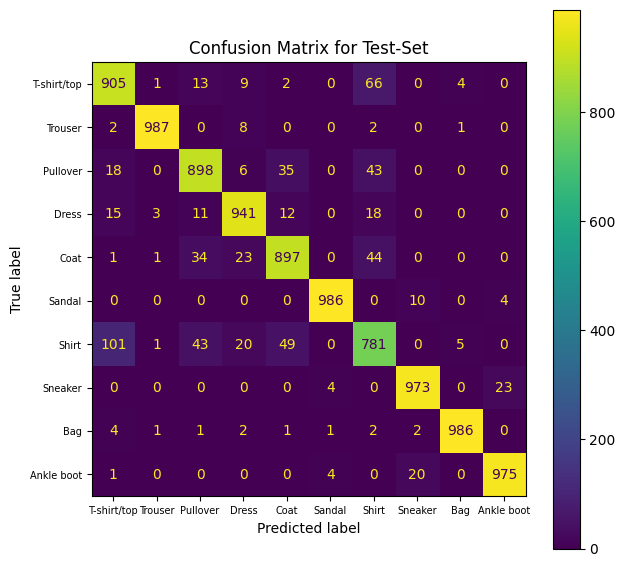

In [154]:
y_true, y_pred, y_scores = plot_confusion_matrix(cnn_model, test_loader)

### Compute and visualize accuracy, precion, recall and F1-Score:

In [86]:

report = classification_report(y_true, y_pred, labels=np.arange(num_classes))
print(report)

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.90      0.90      0.90      1000
           3       0.93      0.94      0.94      1000
           4       0.90      0.90      0.90      1000
           5       0.99      0.99      0.99      1000
           6       0.82      0.78      0.80      1000
           7       0.97      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



### Compute and visualize Precision-Recall curve for different classes:

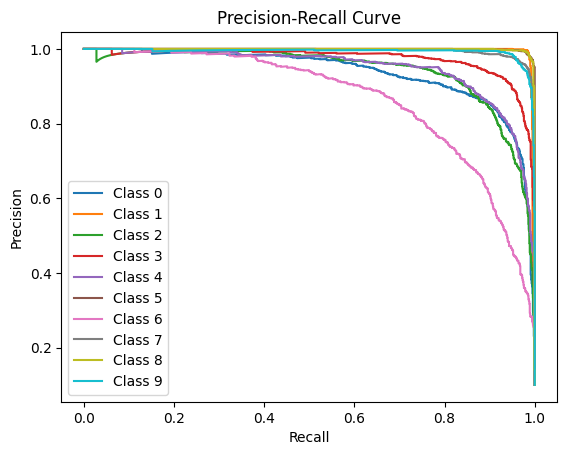

In [87]:
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
y_scores = np.array(y_scores)
precision, recall = None, None
for i in range(len(all_classes)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.show()

### Visualze example images with predicted classes:

Acual Labels: ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser', 'Coat', 'Shirt', 'Sandal', 'Sneaker']
Predicted Labels: ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser', 'Coat', 'Shirt', 'Sandal', 'Sneaker']


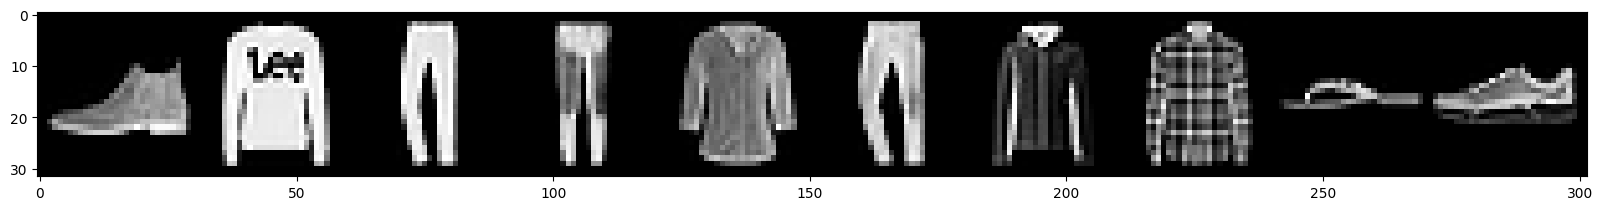

In [88]:
k = 10
x = [test_dataset1[i][0] for i in range(k)]
labels = [idx_to_class[test_dataset1[i][1]] for i in range(k)]
print(f"Acual Labels: {labels}")
print(f"Predicted Labels: {[all_classes[pred_class] for pred_class in y_pred[:k]]}")

plt.figure(figsize=(20, 10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

# Task 2: Image Denoising
1. define a Neural Network
2. define optimization procedure on NoisyFashionMNIST
3. train denoising model
4. Evaluate model

## Dataset
Random augmentations are added to the original dataset.

In [90]:
train_dataset2 = NoisyFashionMNIST("./data", True)
test_dataset2 = NoisyFashionMNIST("./data", False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33280858..1.3520023].


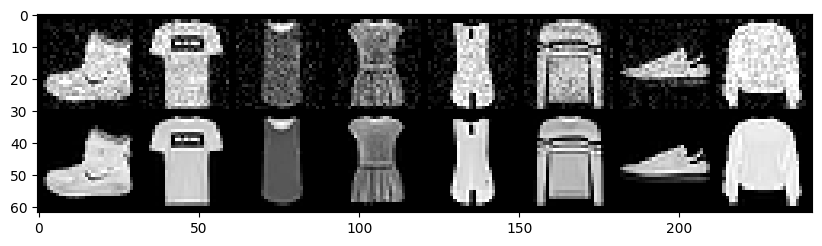

In [126]:
n = 8
x = [train_dataset2[i][0] for i in range(n)]
y = [train_dataset2[i][1] for i in range(n)]
plt.figure(figsize=(10, 10))
show(torchvision.utils.make_grid(x + y, nrow=n))
plt.show()

## Model Architecture:
An Encoder-Decoder Architecture with Conv-Layers for encoder and ConvTranspose-Layers for decoder.

In [93]:
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # define encoding layers for extracting features
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # define decoding layers for reconstructing images
        self.trans_conv1 = nn.ConvTranspose2d(64, 32, 3, 1)
        self.trans_conv2 = nn.ConvTranspose2d(32, 1, 3, 1)

    def forward(self, x):
        # encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # decoder
        x = F.relu(self.trans_conv1(x))
        x = F.tanh(self.trans_conv2(x))
        return x

## Training- and Test-Routine:

In [94]:
def train_denoising_model(
    model, 
    device, 
    train_loader, 
    optimizer, 
    epoch
):
    model.train()
    for batch_idx, (noisy, target) in enumerate(train_loader):
        noisy, target = noisy.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(noisy) # predicted label of the model
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            data_processed_so_far = batch_idx * len(target)
            total_data = len(train_loader.dataset)
            progress = 100. * batch_idx / len(train_loader)
            print("Train Epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, data_processed_so_far, total_data, progress, loss.item()
            ), end="\r")


def test_denoising_model(
    model, 
    device, 
    test_loader, 
    epoch,
):
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for (noisy, target) in test_loader:
            noisy, target = noisy.to(device), target.to(device)
            output = model(noisy)
            test_loss += F.mse_loss(output, target, reduction="sum").item() # sum up batch loss
    
    total_data = len(test_loader.dataset)
    test_loss /= total_data
    print("Test Set (Epoch {}): Average Loss: {:.4f}{}".format(epoch, test_loss, 80 * " "))

## Hyperparameters with Training-Loop:

In [97]:
batch_size = 64
noisy_train_loader = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size)
noisy_test_loader = torch.utils.data.DataLoader(test_dataset2, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
autoencoder_model = AutoEncoder().to(device=device)
train_model(
    autoencoder_model,
    device,
    noisy_train_loader,
    noisy_test_loader,
    train_denoising_model,
    test_denoising_model
)

Test Set (Epoch 1): Average Loss: 1.8356                                                                                
Test Set (Epoch 2): Average Loss: 1.6730                                                                                
Test Set (Epoch 3): Average Loss: 1.6153                                                                                
Test Set (Epoch 4): Average Loss: 1.5692                                                                                
Test Set (Epoch 5): Average Loss: 1.5253                                                                                
Test Set (Epoch 6): Average Loss: 1.5093                                                                                
Test Set (Epoch 7): Average Loss: 1.5075                                                                                
Test Set (Epoch 8): Average Loss: 1.5029                                                                                
Test Set (Epoch 9): Average Loss

## Evaluate model on Test-Set:

In [162]:
# plot results

def plot_denoising_results(model, dataset, n=8):
    # plot original and noisy test images
    x = [dataset[i][1] for i in range(n)]
    y = [dataset[i][0] for i in range(n)]
    # plot reconstructed test images
    with torch.no_grad():
        data = torch.stack(y).to(device) # noisy images
        output = model(data).cpu()
        z = [img for img in output]

    plt.figure(figsize=(10, 10))
    show(torchvision.utils.make_grid(x + y + z, nrow=n))
    ax = plt.gca()
    plt.text(-0.03, 0.83, "Original", transform=ax.transAxes, fontsize=14, va="center", ha="right", color="blue")
    plt.text(-0.03, 0.50, "Noisy", transform=ax.transAxes, fontsize=14, va="center", ha="right", color="darkorange")
    plt.text(-0.03, 0.17, "Reconstructed", transform=ax.transAxes, fontsize=14, va="center", ha="right", color="green")
    plt.title("Denoising Results")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34692368..1.2215533].


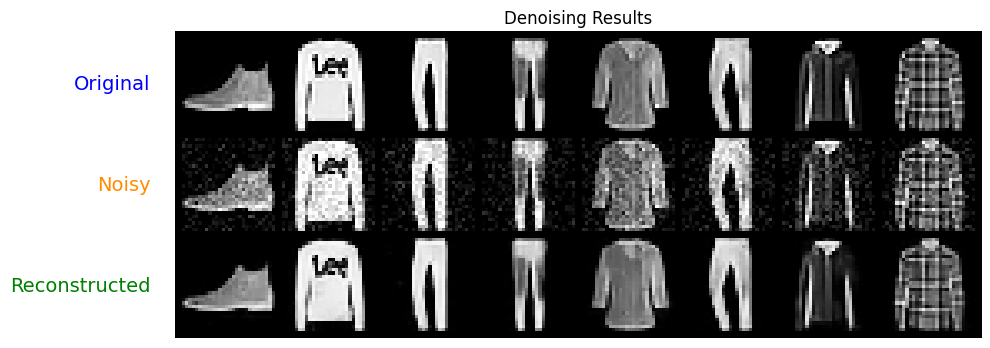

In [163]:
plot_denoising_results(autoencoder_model, test_dataset2)

# Task 3: Model Selection

Conduct at least **3 experiments** for **each** of the previous tasks and document them (i.e. at least 6 experiments).  
Evaluate the effect of different parameters on the classification and denoising tasks.  
Conduct the following experiments:
- Evaluate the effect of residual connections
- Evaluate the effect of the depth(number of layers)/width (number of channels or number of neurons) of the network  
- Evaluate the effect of Batch normalization

## Optional experiments:
- How does the loss function affect denoising? Alternative loss functions: MSE, MAE, SSIM?
- How does Dropout affect the performance?
- Use different downsampling/upsampling layers, e.g.pooling, strided convolution, transposed convolution, etc.  
- Feel free to explore more variations of your model and training.

## Three experiments for the classification model from Task 1

### 1. Experiment: Residual Connections

In [99]:
import torch.nn as nn

def creatConvModule(
    in_channels, 
    out_channels,
    kernel_size=3,
    stride=1,
    padding=0, 
    trans_conv=False
):
    conv = None
    if not trans_conv:
        conv = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
    else:
        conv = nn.ConvTranspose2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )

    return conv

class ResidualBlock(nn.Module):

    def __init__(self, 
        in_channels, 
        out_channels, 
        batch_norm=False, 
        trans_conv=False,
        use_tanh=False
    ):
        super(ResidualBlock, self).__init__()
        self.conv = creatConvModule(
            in_channels, 
            out_channels, 
            padding=1, 
            trans_conv=trans_conv
        )

        self.activation = nn.Tanh() if use_tanh else nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else None

        self.downsample = None
        if in_channels != out_channels:
            self.downsample = creatConvModule(
                in_channels, 
                out_channels, 
                kernel_size=1, 
                trans_conv=trans_conv
            )
    
    def forward(self, x):

        residual = x
        if self.downsample:
            residual = self.downsample(residual)
            residual = self.bn1(residual) if self.bn1 else residual

        x = self.bn2(self.conv(x)) if self.bn2 else self.conv(x)
        x = self.activation(x + residual)

        return x

class ResCNN(nn.Module):

    def __init__(self):
        super(ResCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            ResidualBlock(1, 32)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(12544, 2048),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 10)
        )

    def forward(self, x):

        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        
        return x # raw logits - log-softmax not neccessary since cross-entropy accounts for it

In [100]:
res_cnn_model = ResCNN().to(device=device)
train_model(
    res_cnn_model,
    device,
    train_loader,
    test_loader,
    train_classification_model, 
    test_classification_model
)

Test Set (Epoch 1): Average Loss: 0.3790	Accuracy: 8641/10000 (86%)                                                                                
Test Set (Epoch 2): Average Loss: 0.3234	Accuracy: 8817/10000 (88%)                                                                                
Test Set (Epoch 3): Average Loss: 0.2885	Accuracy: 8970/10000 (90%)                                                                                
Test Set (Epoch 4): Average Loss: 0.2644	Accuracy: 9041/10000 (90%)                                                                                
Test Set (Epoch 5): Average Loss: 0.2805	Accuracy: 9032/10000 (90%)                                                                                
Test Set (Epoch 6): Average Loss: 0.2417	Accuracy: 9205/10000 (92%)                                                                                
Test Set (Epoch 7): Average Loss: 0.2478	Accuracy: 9219/10000 (92%)                                             

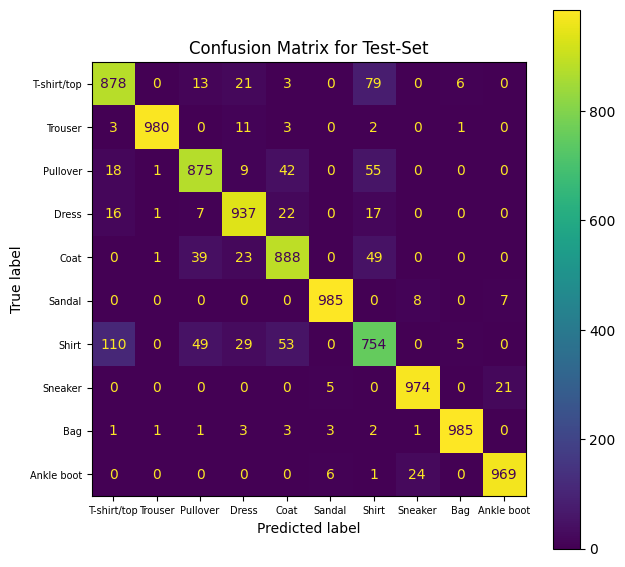

In [155]:
y_true, y_pred, y_scores = plot_confusion_matrix(res_cnn_model, test_loader)

### Conclusion:
CNN with residual blocks does not perform better as the one without in this specific case while the computational cost and runtime is higher. Accuracy is approximately same when model is trained several times. Moreover, residual blocks are more suitable for deep architectures. Our particular model is quite shallow.

### 2. Experiment: Batch Normalization 

In [101]:
import torch.nn as nn

class ResBatchCNN(nn.Module):
    
    def __init__(self):
        super(ResBatchCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            ResidualBlock(1, 32, batch_norm=True)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, batch_norm=True),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(12544, 2048),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x # raw logits - log-softmax not neccessary since cross-entropy accounts for it

In [102]:
res_batch_cnn_model = ResBatchCNN().to(device=device)
train_model(
    res_batch_cnn_model,
    device,
    train_loader,
    test_loader,
    train_classification_model, 
    test_classification_model
)

Test Set (Epoch 1): Average Loss: 0.2986	Accuracy: 8905/10000 (89%)                                                                                
Test Set (Epoch 2): Average Loss: 0.2437	Accuracy: 9151/10000 (92%)                                                                                
Test Set (Epoch 3): Average Loss: 0.2592	Accuracy: 9135/10000 (91%)                                                                                
Test Set (Epoch 4): Average Loss: 0.2304	Accuracy: 9238/10000 (92%)                                                                                
Test Set (Epoch 5): Average Loss: 0.2964	Accuracy: 9147/10000 (91%)                                                                                
Test Set (Epoch 6): Average Loss: 0.2520	Accuracy: 9361/10000 (94%)                                                                                
Test Set (Epoch 7): Average Loss: 0.2683	Accuracy: 9380/10000 (94%)                                             

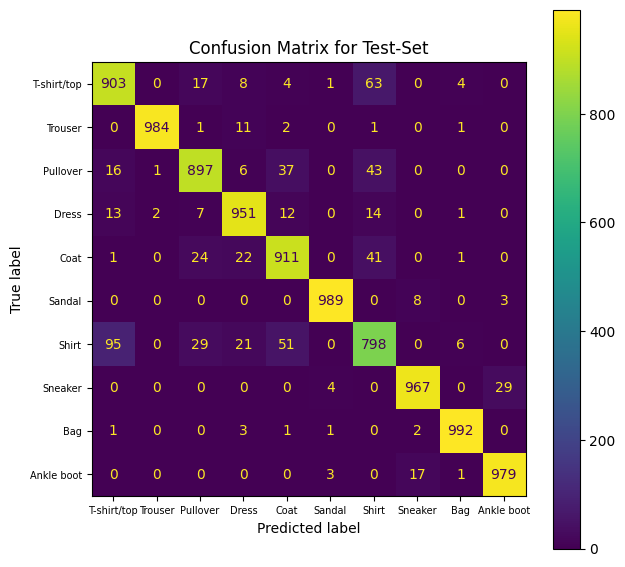

In [156]:
y_true, y_pred, y_scores = plot_confusion_matrix(res_batch_cnn_model, test_loader)

### Conclusion:
Using batch normalization and residual connection combined yields slightly better performance than the vanilla and residual approach.

### 3. Experiment: Deeper Architecture and more Channels

In [104]:
import torch.nn as nn

class DeepResBatchCNN(nn.Module):
    def __init__(self):
        super(DeepResBatchCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            ResidualBlock(1, 32, batch_norm=True),
            ResidualBlock(32, 32, batch_norm=True)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, batch_norm=True),
            ResidualBlock(64, 64, batch_norm=True),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128, batch_norm=True),
            ResidualBlock(128, 128, batch_norm=True),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(12544, 2048),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x # raw logits - log-softmax not neccessary since cross-entropy accounts for it

In [105]:
deep_res_batch_cnn_model = DeepResBatchCNN().to(device=device)
train_model(
    deep_res_batch_cnn_model,
    device,
    train_loader,
    test_loader,
    train_classification_model, 
    test_classification_model
)

Test Set (Epoch 1): Average Loss: 0.3556	Accuracy: 8635/10000 (86%)                                                                                
Test Set (Epoch 2): Average Loss: 0.2696	Accuracy: 9041/10000 (90%)                                                                                
Test Set (Epoch 3): Average Loss: 0.2413	Accuracy: 9140/10000 (91%)                                                                                
Test Set (Epoch 4): Average Loss: 0.2648	Accuracy: 9165/10000 (92%)                                                                                
Test Set (Epoch 5): Average Loss: 0.2329	Accuracy: 9279/10000 (93%)                                                                                
Test Set (Epoch 6): Average Loss: 0.2103	Accuracy: 9371/10000 (94%)                                                                                
Test Set (Epoch 7): Average Loss: 0.2250	Accuracy: 9367/10000 (94%)                                             

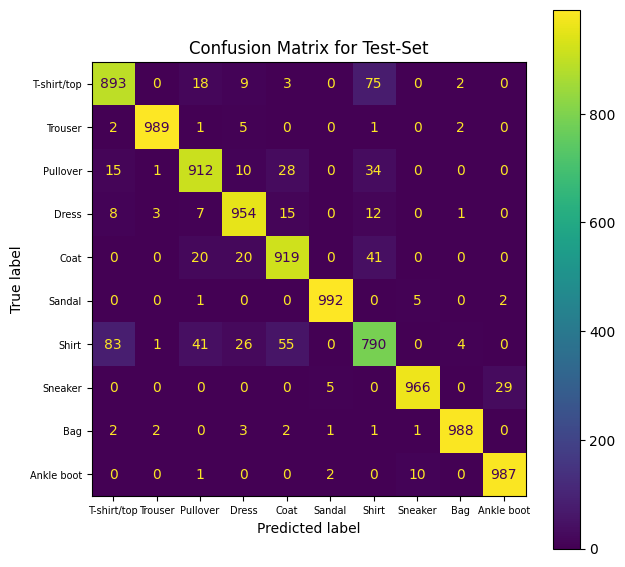

In [157]:
y_true, y_pred, y_scores = plot_confusion_matrix(deep_res_batch_cnn_model, test_loader)

### Conclusion:
Deeper architecture combined with more channels again yields slighlty better results than the previous models, but at the expense of more computational cost.

## Three experiments for the denoising model from Task 2

### 1. Experiment: Residual Connections

In [110]:
import torch.nn as nn

class ResAutoEncoder(nn.Module):
    def __init__(self):
        super(ResAutoEncoder, self).__init__()
        # define encoding layers for extracting features
        self.encoder = nn.Sequential(
            ResidualBlock(1, 32),
            ResidualBlock(32, 64)
        )
        # define decoding layers for reconstructing images
        self.decoder = nn.Sequential(
            ResidualBlock(64, 32, trans_conv=True),
            ResidualBlock(32, 1, trans_conv=True, use_tanh=True)
        )

    def forward(self, x):
        # encoder
        x = self.encoder(x)
        # decoder
        x = self.decoder(x)
        return x

In [111]:
res_autoencoder_model = ResAutoEncoder().to(device=device)
train_model(
    res_autoencoder_model,
    device,
    noisy_train_loader,
    noisy_test_loader,
    train_denoising_model,
    test_denoising_model
)

Test Set (Epoch 1): Average Loss: 1.7320                                                                                
Test Set (Epoch 2): Average Loss: 1.6253                                                                                
Test Set (Epoch 3): Average Loss: 1.5817                                                                                
Test Set (Epoch 4): Average Loss: 1.5433                                                                                
Test Set (Epoch 5): Average Loss: 1.5538                                                                                
Test Set (Epoch 6): Average Loss: 1.5038                                                                                
Test Set (Epoch 7): Average Loss: 1.5018                                                                                
Test Set (Epoch 8): Average Loss: 1.4965                                                                                
Test Set (Epoch 9): Average Loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36986503..1.3077624].


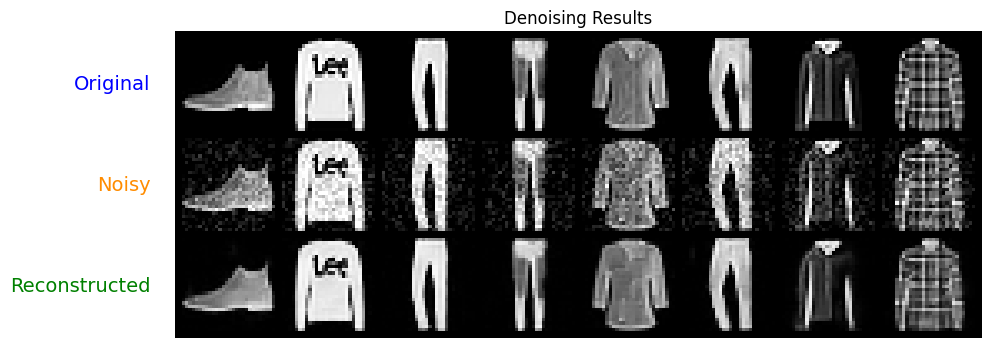

In [164]:
plot_denoising_results(res_autoencoder_model, test_dataset2)

### 2. Experiment: Batch Normalization

In [168]:
import torch.nn as nn

class ResBatchAutoEncoder(nn.Module):
    def __init__(self):
        super(ResBatchAutoEncoder, self).__init__()
        # define encoding layers for extracting features
        self.encoder = nn.Sequential(
            ResidualBlock(1, 32, batch_norm=True),
            ResidualBlock(32, 64, batch_norm=True)
        )
        # define decoding layers for reconstructing images
        self.decoder = nn.Sequential(
            ResidualBlock(64, 32, batch_norm=True, trans_conv=True),
            ResidualBlock(32, 1, batch_norm=True, trans_conv=True, use_tanh=True)
        )

    def forward(self, x):
        # encoder
        x = self.encoder(x)
        # decoder
        x = self.decoder(x)
        return x

In [169]:
res_batch_autoencoder_model = ResBatchAutoEncoder().to(device=device)
train_model(
    res_batch_autoencoder_model,
    device,
    noisy_train_loader,
    noisy_test_loader,
    train_denoising_model,
    test_denoising_model
)

Test Set (Epoch 1): Average Loss: 2.0159                                                                                
Test Set (Epoch 2): Average Loss: 1.8152                                                                                
Test Set (Epoch 3): Average Loss: 1.7136                                                                                
Test Set (Epoch 4): Average Loss: 1.6339                                                                                
Test Set (Epoch 5): Average Loss: 1.5663                                                                                
Test Set (Epoch 6): Average Loss: 1.5327                                                                                
Test Set (Epoch 7): Average Loss: 1.5192                                                                                
Test Set (Epoch 8): Average Loss: 1.5158                                                                                
Test Set (Epoch 9): Average Loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35702464..1.226111].


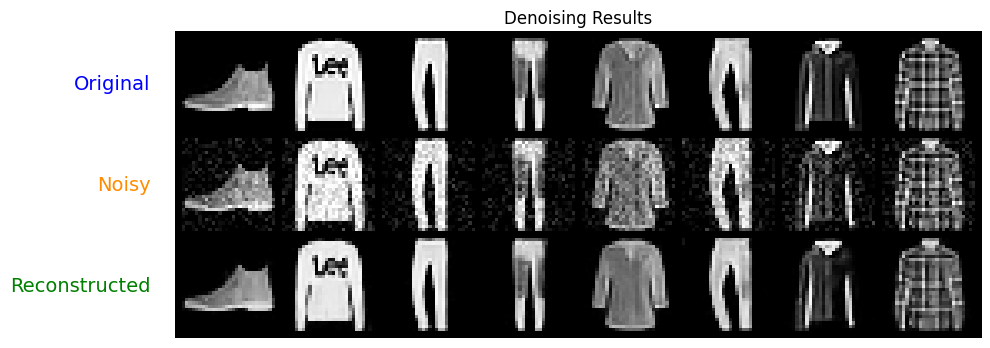

In [173]:
plot_denoising_results(res_batch_autoencoder_model, test_dataset2)

### 3. Experiment: Deeper Architecture and more Channels

In [175]:
import torch.nn as nn

class DeepResBatchAutoEncoder(nn.Module):
    def __init__(self):
        super(DeepResBatchAutoEncoder, self).__init__()
        # define encoding layers for extracting features
        self.encoder = nn.Sequential(
            ResidualBlock(1, 32, batch_norm=True),
            ResidualBlock(32, 32, batch_norm=True),
            ResidualBlock(32, 64, batch_norm=True),
            ResidualBlock(64, 64, batch_norm=True),
            ResidualBlock(64, 128, batch_norm=True)
        )
        # define decoding layers for reconstructing images
        self.decoder = nn.Sequential(
            ResidualBlock(128, 64, batch_norm=True, trans_conv=True),
            ResidualBlock(64, 64, batch_norm=True, trans_conv=True),
            ResidualBlock(64, 32, batch_norm=True, trans_conv=True),
            ResidualBlock(32, 32, batch_norm=True, trans_conv=True),
            ResidualBlock(32, 1, batch_norm=True, trans_conv=True, use_tanh=True)
        )

    def forward(self, x):
        # encoder
        x = self.encoder(x)
        # decoder
        x = self.decoder(x)
        return x

In [172]:
deep_res_batch_autoencoder_model = DeepResBatchAutoEncoder().to(device=device)
train_model(
    deep_res_batch_autoencoder_model,
    device,
    noisy_train_loader,
    noisy_test_loader,
    train_denoising_model,
    test_denoising_model
)

Test Set (Epoch 1): Average Loss: 2.4761                                                                                
Test Set (Epoch 2): Average Loss: 1.6477                                                                                
Test Set (Epoch 3): Average Loss: 1.6227                                                                                
Test Set (Epoch 4): Average Loss: 1.5919                                                                                
Test Set (Epoch 5): Average Loss: 1.5432                                                                                
Test Set (Epoch 6): Average Loss: 1.3847                                                                                
Test Set (Epoch 7): Average Loss: 1.3765                                                                                
Test Set (Epoch 8): Average Loss: 1.3699                                                                                
Test Set (Epoch 9): Average Loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42505994..1.2750483].


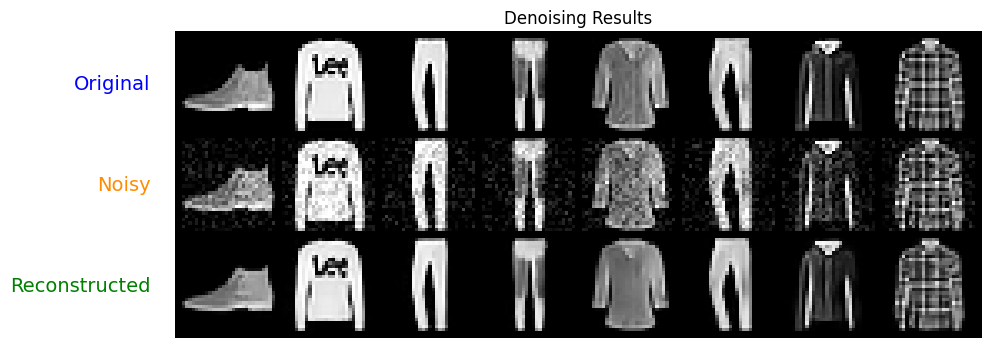

In [176]:
plot_denoising_results(deep_res_batch_autoencoder_model, test_dataset2)